### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


In [2]:
# For saving the model in Pickle file
import types
import tempfile
import keras.models

def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            keras.models.save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = { 'model_str': model_str }
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = keras.models.load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = keras.models.Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

make_keras_picklable()

#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [4]:
# Initialising the States_tracked (for convergence) for storing the Q values

States_track = collections.defaultdict(dict)

In [5]:
# Initialising states to be tracked
def initialise_tracking_states():
    # selecting any 5 Q-values
    sample_q_values = [((1,13,5),(1,4)),((2,7,1),(3,5)), ((3,19,4),(2,1)), ((4,2,0),(3,5)), ((5,22,6),(5,1))]
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [6]:
# Defining a function to save the tracked states, rewards, loss as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        
        self.discount_factor = 0.99
        self.learning_rate = 0.01    
        self.epsilon_max = 1
        self.epsilon = 1
        self.epsilon_decay = 0.0009
        self.epsilon_min = 0.01
        
        self.batch_size = 32
        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create the model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        
        input_shape = self.state_size
        output_shape = self.action_size
        
        model = Sequential()
        
        # Write your code here: Add layers to your neural nets 
        
        # hidden layers
        model.add(Dense(32, input_dim=input_shape, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        # the output layer: output is of size num_actions
        model.add(Dense(output_shape, activation='relu', kernel_initializer='he_uniform'))
        
        model.summary()
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        
        return model



    def get_action(self, state, time):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment
    
        # Get the requests from the environment
        possible_actions_index, actions = env.requests(state)
        
        # Exploring the action space
        if np.random.rand() <= self.epsilon:
            
            action = actions[random.randrange(len(actions))]
            
        else:
            # Exploiting or the greedy approach
            
            # the first index corresponds to the batch size, so reshaping
            # Also encoding the state to be feb to the network
            state = env.state_encod_arch1(state).reshape(1, self.state_size)
            q_value = self.model.predict(state)
            
            # choose the action with the highest q(s, a) among the requests that have come from the environment
            # that is, choose max from within the possible_actions_index
            
            action = actions[np.argmax(q_value[0][possible_actions_index])]
        
        # implement epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*time)
        
        return action  
        


    def append_sample(self, state, action, reward, next_state):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state))
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    # Trains the NN model and returns the loss after training
    def train_model(self):

        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            
            # Create placeholders for state vectors
            update_output = np.zeros((self.batch_size, self.state_size))# write here
            update_input = np.zeros((self.batch_size, self.state_size))# write here
            
            actions, rewards = [], []
            
            # Pick sample from memory
            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)                

            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)

            #3. Update the target values
            for i in range(self.batch_size):
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
                
        # 4. Fit your model and track the loss values
            history = self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
            # return the loss
            return history.history['loss'][0]
        
        return 0

    # Save the model
    def save(self, name):
        self.model.save(name)
    
    # Function to store the q values in the states tracked dictionary for tracking the convergence
    def store_q_values(self):
        
        for state in States_track.keys():
            qvals = self.model.predict(env.state_encod_arch1(state).reshape(1, self.state_size))
            for action in States_track[state].keys():
                i = action_space.index(action)
                States_track[state][action].append(qvals[0][i]) 

In [8]:
# Define number of episodes for training
Episodes = 10000

### DQN block

In [9]:
# Define lists to store rewards and loss in each episode
rewards_per_episode, episodes, loss_per_episode = [], [], []

# Write code here

# Call the environment
env = CabDriver()

# Call the DQN agent with input and output size
agent = DQNAgent(state_size = 36, action_size = 21)

# Initialize tracking states
initialise_tracking_states()

# Start the simulation
for episode in range(Episodes):
   
    # Initialize the state
    action_space, state_space, state = env.reset()
  
    # Define some variales for each episode
    terminal_state = False
    total_hours_worked = 0
    score_per_episode = 0
    loss = 0
    
    # Starting with the steps in every episode
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(state, episode)        
        
        # 2. Evaluate your reward and next state
        reward = env.reward_func(state, action, Time_matrix)
        next_state = env.next_state_func(state, action, Time_matrix)
        
        # 3. Append the experience to the memory
        agent.append_sample(state, action_space.index(action), reward, next_state)
        
        # 4. Train the model by calling function agent.train_model
        loss_per_step = agent.train_model()
        
        # 5. Keep a track of rewards and loss
        score_per_episode+=reward
        loss+=loss_per_step
        
        
        # Keeping track of total hours worked for monitoring end of episode
        if action == (0,0):
            total_hours_worked+=1
        else:
            time_ItoP = Time_matrix[state[0]-1][action[0]-1][state[1]][state[2]]
            
            new_time, new_day = env.new_time_day(state[1], state[2], time_ItoP)
            
            time_PtoD = Time_matrix[action[0]-1][action[1]-1][new_time][new_day]
            
            total_hours_worked = total_hours_worked+time_ItoP+time_PtoD
        
        # Episode ends after a month, that is 24*30 hours
        if total_hours_worked >= 720:
            terminal_state = True
        
        # Current state transition to next state
        state = next_state
    
    # store total reward obtained and total loss in this episode
    rewards_per_episode.append(score_per_episode)
    episodes.append(episode)
    loss_per_episode.append(loss)

    
    # For every few episodes...
    
    if episode % 50 == 0:
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, loss {4}".format(episode,
                                                                         score_per_episode,
                                                                         len(agent.memory),
                                                                         agent.epsilon,loss))
        # Keeping track of Q values
        # store q-values of some prespecified state-action pairs
        agent.store_q_values()

        # save model weights
        agent.save(name="model_weights.h5")
        
        save_obj(agent.model, 'trained_model')
        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1184      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 21)                693       
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________
episode 0, reward -339.0, memory_length 142, epsilon 1.0, loss 11004667.240115166
episode 50, reward -64.0, memory_length 2000, epsilon 0.9564375070147689, loss 2992617.8466796875
episode 100, reward -114.0, memory_length 2000, epsilon 0.9147918734185159, loss 573276881.375
episode 150, reward 20.0, memory_length 2000, epsilon 0.8749787525711541, loss 1751084.0546875
episode 200, reward 134.0, memory_

episode 3800, reward 894.0, memory_length 2000, epsilon 0.042385310589629625, loss 2735307.046432972
episode 3850, reward 629.0, memory_length 2000, epsilon 0.04096027537206874, loss 14648698.405418396
episode 3900, reward 975.0, memory_length 2000, epsilon 0.03959794529255706, loss 2612191.834731102
episode 3950, reward 1153.0, memory_length 2000, epsilon 0.0382955611671184, loss 2390467.1729431152
episode 4000, reward 1006.0, memory_length 2000, epsilon 0.03705048522281963, loss 2047800.657251358
episode 4050, reward 1249.0, memory_length 2000, epsilon 0.03586019575537905, loss 2066509.5466227531
episode 4100, reward 1192.0, memory_length 2000, epsilon 0.034722282021853394, loss 1845144.6305794716
episode 4150, reward 1205.0, memory_length 2000, epsilon 0.03363443935805956, loss 2779578.554233074
episode 4200, reward -1.0, memory_length 2000, epsilon 0.03259446451084205, loss 645486538.5836792
episode 4250, reward 1227.0, memory_length 2000, epsilon 0.03160025117573235, loss 2433952.

episode 7850, reward 1880.0, memory_length 2000, epsilon 0.010845949971158154, loss 142047.6808423996
episode 7900, reward 1640.0, memory_length 2000, epsilon 0.01080872604218398, loss 50734.809077858925
episode 7950, reward 1812.0, memory_length 2000, epsilon 0.010773140059820734, loss 24405.73357105255
episode 8000, reward 1385.0, memory_length 2000, epsilon 0.010739119950292912, loss 122643.41235589981
episode 8050, reward 1406.0, memory_length 2000, epsilon 0.01070659681125263, loss 79312.41121053696
episode 8100, reward 940.0, memory_length 2000, epsilon 0.010675504772228813, loss 319617.60419654846
episode 8150, reward 1655.0, memory_length 2000, epsilon 0.010645780861216987, loss 46483.28742647171
episode 8200, reward 1817.0, memory_length 2000, epsilon 0.01061736487713945, loss 10570.143432378769
episode 8250, reward 857.0, memory_length 2000, epsilon 0.010590199267917516, loss 380761.5647678375
episode 8300, reward 1353.0, memory_length 2000, epsilon 0.010564229013908884, loss

In [10]:
# save the rewards_per_episode, loss and tracked state-action pairs
save_obj(rewards_per_episode, 'rewards_per_episode')
save_obj(loss_per_episode,'loss_per_episode')
save_obj(States_track,'States_track')

### Tracking Convergence

Text(0,0.5,'reward per episode')

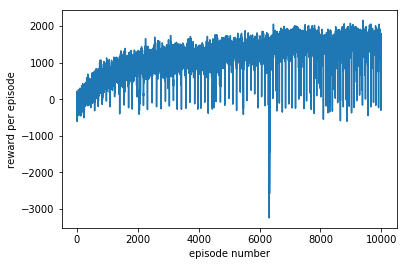

In [11]:
# Load the rewards and plot the results
with open('rewards_per_episode.pkl', 'rb') as f:
    rewards_per_episode = pickle.load(f)

plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("reward per episode")

Text(0,0.5,'loss per episode')

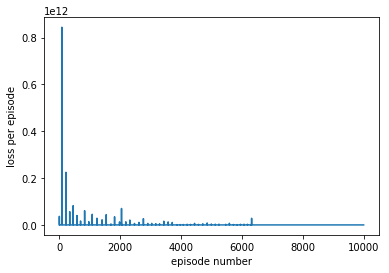

In [12]:
# Load the loss and plot the results
with open('loss_per_episode.pkl', 'rb') as f:
    loss_per_episode = pickle.load(f)

plt.plot(list(range(len(loss_per_episode))), loss_per_episode)
plt.xlabel("episode number")
plt.ylabel("loss per episode")

In [13]:
# Load the q values of state action pairs
with open('States_track.pkl', 'rb') as f:
    States_track = pickle.load(f)

<function matplotlib.pyplot.show(*args, **kw)>

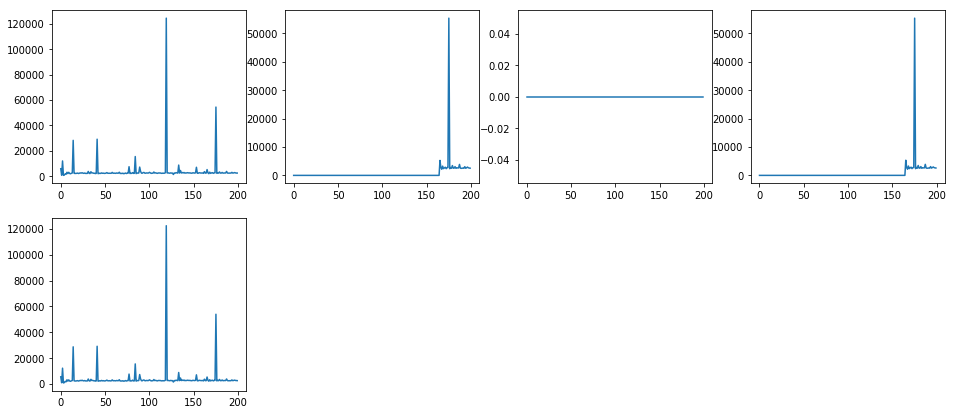

In [14]:
# Tracked state action pairs
#[((1,13,5),(1,4)),((2,7,1),(3,5)), ((3,19,4),(2,1)), ((4,2,0),(3,5)), ((5,22,6),(5,1))]
# Plot the results

plt.figure(0, figsize=(16,7))

xaxis = np.asarray(range(0, len(States_track[(1,13,5)][(1,4)])))
plt.subplot(241)
plt.plot(xaxis,np.asarray(States_track[(1,13,5)][(1,4)]))
plt.show

xaxis = np.asarray(range(0, len(States_track[(2,7,1)][(3,5)])))
plt.subplot(242)
plt.plot(xaxis,np.asarray(States_track[(2,7,1)][(3,5)]))
plt.show

xaxis = np.asarray(range(0, len(States_track[(3,19,4)][(2,1)])))
plt.subplot(243)
plt.plot(xaxis,np.asarray(States_track[(3,19,4)][(2,1)]))
plt.show

xaxis = np.asarray(range(0, len(States_track[(4,2,0)][(3,5)])))
plt.subplot(244)
plt.plot(xaxis,np.asarray(States_track[(4,2,0)][(3,5)]))
plt.show

xaxis = np.asarray(range(0, len(States_track[(5,22,6)][(5,1)])))
plt.subplot(245)
plt.plot(xaxis,np.asarray(States_track[(5,22,6)][(5,1)]))
plt.show

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [15]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0.01 + (1 - 0.01) * np.exp(-0.0009*i))

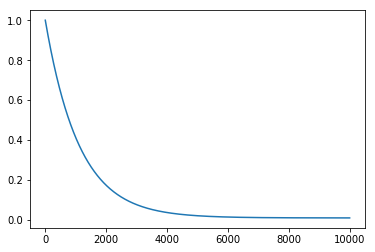

In [16]:
plt.plot(time, epsilon)
plt.show()